## NNConv

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root)

To run the notebook on Google Colab (uncomment the shell commands. Silenced as safeguard):

In [8]:
# --- Remove any existing conflicting installs ---
# !pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

# --- Install PyTorch with CUDA 12.1 (compatible with PyG) ---
# %pip install torch==2.3.0+cu121 torchvision==0.18.0+cu121 torchaudio==2.3.0+cu121 \
#     --extra-index-url https://download.pytorch.org/whl/cu121 --quiet

# --- Install the PyG dependencies (compiled wheels for PyTorch 2.3.0 + cu121) ---
# %pip install torch-scatter torch-sparse torch-cluster torch-spline-conv \
#     -f https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html --quiet

# --- Install torch-geometric itself ---
# %pip install torch-geometric --quiet

# --- Verify installation ---
import torch
import torch_geometric
import torch_cluster

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyG:", torch_geometric.__version__)
print("torch-cluster:", torch_cluster.__version__)


Torch: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
PyG: 2.7.0
torch-cluster: 1.6.3+pt28cu128


In [2]:
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import scripts.data.dataset as ds
from scripts.model.nnconv import NNConvModel
from scripts.train.train import train_one_epoch
from scripts.evaluate.evaluate import evaluate, compare_ytrue_ypred


/home/alex/miniconda3/envs/torch28/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Select GPU if run in Google Colab

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


### Preparing the dataset

Download the dataset

In [ ]:
dataset = ds.load_qm9_dataset(root=f"{root}/data/QM9")
ds.describe_dataset(dataset)

Dataset: QM9(100):
[====================]
Number of graphs: 100
Number of features: 11
Number of classes: 19

First node data:
[====================]
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Split the dataset into training and test sets

In [10]:
train_dataset, test_dataset = ds.split_dataset(dataset, training_perc=0.9)

Number of training graphs: 90
Number of test graphs: 10


Normalize the target property in the training set

In [11]:
target_idx = 11
train_mean, train_std = ds.normalize_train_set(train_dataset, target_idx=target_idx)
train_mean = train_mean.to(device)
train_std = train_std.to(device)

Target statistics - Mean: 16.6048, Std: 4.5179


Create the DataLoaders for the training and test sets

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Training

In [ ]:
# Model, optimizer, loss, scheduler
model = NNConvModel(input_channels=dataset.num_node_features,
               hidden_channels=128, num_layers=5).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

# Training loop with early stopping and checkpointing
max_epochs = 500
patience = 20
min_delta = 1e-4
best_val = float('inf')
epochs_no_improve = 0
save_path = f"{root}/models/nnconv.pt"

print("Starting training...")
for epoch in range(1, max_epochs + 1):

    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device,
        train_mean, train_std, target_idx, model_type="nnconv")
    
    train_mae = evaluate(
        model, train_loader, device, train_mean,
        train_std, target_idx, model_type="nnconv")
    val_mae = evaluate(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="nnconv")
    
    scheduler.step(val_mae)

    # Check for improvement and checkpoint
    if val_mae < best_val - min_delta:
        best_val = val_mae
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        improved = " *"
    else:
        epochs_no_improve += 1
        improved = ""

    if epoch % 5 == 0 or epochs_no_improve == 0:
        print(f"[*] Epoch {epoch:03d}  Train loss: {train_loss:.4f}  Train MAE: {train_mae:.4f}  Val MAE: {val_mae:.4f}{improved}")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} (no val MAE improvement for {patience} epochs).")
        break


# Load best model for final evaluation
model.load_state_dict(torch.load(save_path))
final_val = evaluate(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="nnconv")

print(f"Best validation MAE: {best_val:.4f}")
print(f"Final evaluated MAE: {final_val:.4f}")
print(f"Test set mean: {train_mean:.4f}, std: {train_std:.4f}")
print(f"Relative MAE: {(best_val/train_std.abs()):.4f} standard deviations")

# Compare to baseline (predicting mean)
baseline_mae = train_std.abs().item()
print(f"Baseline MAE (predicting mean): {baseline_mae:.4f}")
print(f"Improvement over baseline: {(baseline_mae/best_val):.2f}x")

Best validation MAE: 1.8769
Final evaluated MAE: 1.8769
Test set mean: 16.6048, std: 4.5179
Relative MAE: 0.4154 standard deviations
Baseline MAE (predicting mean): 4.5179
Improvement over baseline: 2.41x


### Testing the performance

In [17]:
model = NNConvModel(input_channels=dataset.num_node_features,
                   hidden_channels=128, num_layers=5).to(device)
model.load_state_dict(torch.load(f'{root}/models/nnconv.pt'))
model.to(device)

test_mae = evaluate(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="nnconv")

print(f"Test set MAE: {test_mae:.4f}")
print(f"Test set mean: {train_mean:.4f}, std: {train_std:.4f}")
print(f"Relative MAE: {(test_mae/train_std.abs()):.4f} standard deviations")

Test set MAE: 1.8769
Test set mean: 16.6048, std: 4.5179
Relative MAE: 0.4154 standard deviations


R² score on test set: 0.8081


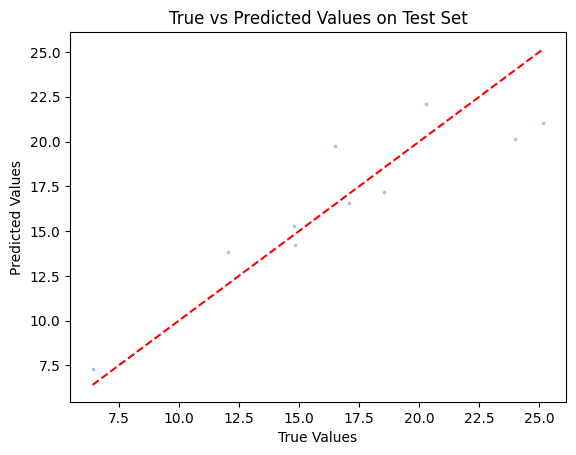

In [18]:
ytrue, ypred = compare_ytrue_ypred(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="nnconv")
ytrue = torch.cat(ytrue).cpu().numpy()
ypred = torch.cat(ypred).cpu().numpy()

# Calculate R² score
r2 = r2_score(ytrue, ypred)
print(f"R² score on test set: {r2:.4f}")

# Plot true vs predicted valuesS
plt.scatter(ytrue, ypred, alpha=0.3, s=3)
plt.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values on Test Set")
plt.show()